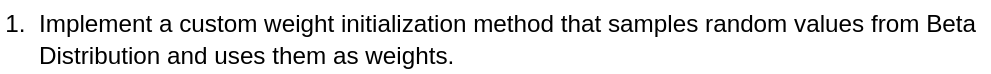

In [ ]:
import torch
import torch.nn as nn
from torch.distributions.beta import Beta

In [ ]:
class BetaInit:
  def __init__(self,alpha=2,beta=2):
    self.alpha = alpha
    self.beta = beta
  def __call__(self,tensor):
    init_tensors = torch.Tensor(tensor.size()).uniform_()
    Beta = Beta(self.alpha,self.beta)
    beta_tensors = Beta.sample(tensor.size())
    return beta_tensors * init_tensors

class NeuralNetwork(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.Layer1 = nn.Linear(input_size,hidden_size)
    self.output = nn.Linear(hidden_size,output_size)
    self.weight_init()

  def forward(self,x):
    x1 = torch.relu(self.Layer1(x))
    return self.output(x1)

  def weight_init(self):
    init = BetaInit()
    init(self.Layer1)
    init(self.output)

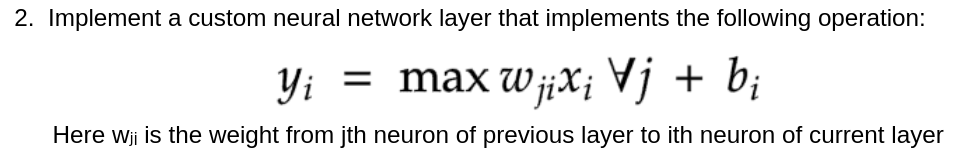

In [ ]:
class CustomLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomLayer, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(input_size, output_size))
        self.biases = nn.Parameter(torch.Tensor(output_size))

    def forward(self, x):
        weighted_sum = torch.matmul(self.weights, x.t()) + self.biases.unsqueeze(1)
        return weighted_sum.max(dim=0).values

## Therefore the new NN would look like:
class NeuralNetwork(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.Layer1 = CustomLayer(input_size = input_size, output_size=hidden_size)
    self.output = nn.Linear(hidden_size,output_size)
    self.weight_init()

  def forward(self,x):
    x1 = torch.relu(self.Layer1(x))
    return self.output(x1)

  def weight_init(self):
    init = BetaInit()
    init(self.Layer1)
    init(self.output)


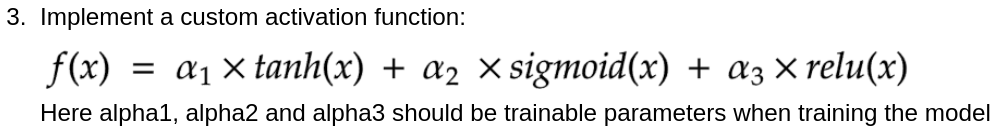

In [ ]:
class CustomActivation(nn.Module):
    def __init__(self, input_size, alpha_init=torch.ones(3)):
        super(CustomActivation, self).__init__()
        self.alpha = nn.Parameter(alpha_init)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        alpha1, alpha2, alpha3 = self.alpha
        y = alpha1 * self.tanh(x) + alpha2 * self.sigmoid(x) + alpha3 * self.relu(x)
        return y

In [ ]:
## Therefore the new NN would look like:
class NeuralNetwork(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.Layer1 = CustomLayer(input_size = input_size, output_size=hidden_size)
    self.output = nn.Linear(hidden_size,output_size)
    self.activation = CustomActivation(hidden_size)
    self.weight_init()

  def forward(self,x):
    x1 = torch.relu(self.Layer1(x))
    x2 = self.activation(x1)
    return self.output(x2)

  def weight_init(self):
    init = BetaInit()
    init(self.Layer1)
    init(self.output)

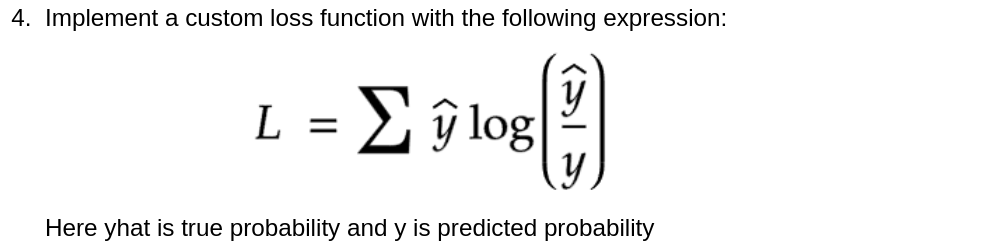

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_hat, y):
        loss = torch.sum(y * torch.log(y_hat/y))
        return loss

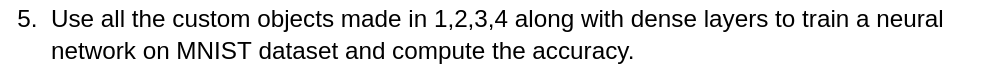

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_hat, y):
        y_onehot = nn.functional.one_hot(y, num_classes=10)
        epsilon = 1e-8
        loss = torch.sum(y_hat * torch.log((y_hat + epsilon) / (y_onehot + epsilon)), dim=0)
        loss = 1.0 * torch.mean(loss)

        # Debugging print statements
        # print("y_hat:", y_hat)
        # print("y_onehot:", y_onehot)
        # print("y_hat/y_onehot:", y_hat / (y_onehot + epsilon))
        # print("log(y_hat/y_onehot):", torch.log((y_hat + epsilon) / (y_onehot + epsilon)))
        # print("loss:", loss)

        return loss

In [ ]:
class CustomActivation(nn.Module):
    def __init__(self, input_size, alpha_init=torch.ones(3)):
        super(CustomActivation, self).__init__()
        self.alpha = nn.Parameter(alpha_init)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        min_alpha, max_alpha = 0.1, 10.0
        clamped_alpha = torch.clamp(self.alpha, min_alpha, max_alpha)
        alpha1, alpha2, alpha3 = clamped_alpha
        y = alpha1 * self.tanh(x) + alpha2 * self.sigmoid(x) + alpha3 * self.relu(x)
        return y


In [ ]:
class CustomLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_size, output_size))
        self.biases = nn.Parameter(torch.Tensor(output_size))
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.biases)

    def forward(self, x):
        weighted_sum = torch.matmul(x, self.weight) + self.biases
        return weighted_sum

In [ ]:
class BetaInit:
    def __init__(self, alpha=2, beta=2):
        self.alpha = alpha
        self.beta = beta

    def __call__(self, tensor):
        in_features = tensor.size(1)
        out_features = tensor.size(0)
        init_tensors = torch.Tensor(out_features, in_features).uniform_()
        Beta = torch.distributions.beta.Beta(self.alpha, self.beta)
        beta_tensors = Beta.sample((out_features, in_features))
        return beta_tensors * init_tensors

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(784, 128)
        self.activation = CustomActivation(128)
        self.layer2 = CustomLayer(128, 10)
        self.weight_init()

    def forward(self, x):
        x1 = torch.relu(self.layer1(x))
        x2 = self.activation(x1)
        x3 = self.layer2(x2)
        y_hat = torch.softmax(x3, dim=1)

        return y_hat

    def weight_init(self):
        init = BetaInit()
        init(self.layer1.weight)
        init(self.layer2.weight)

In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

In [ ]:
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [ ]:
batch_size = 100
learning_rate = 0.001
num_epochs = 10

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = NeuralNetwork()
criterion = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Step [100/600], Loss: 27.2668
Epoch [1/10], Step [200/600], Loss: 9.5824
Epoch [1/10], Step [300/600], Loss: 18.3410
Epoch [1/10], Step [400/600], Loss: 10.3014
Epoch [1/10], Step [500/600], Loss: 10.7346
Epoch [1/10], Step [600/600], Loss: 10.0768
Epoch [2/10], Step [100/600], Loss: 12.1159
Epoch [2/10], Step [200/600], Loss: 15.0478
Epoch [2/10], Step [300/600], Loss: 5.5403
Epoch [2/10], Step [400/600], Loss: 9.5116
Epoch [2/10], Step [500/600], Loss: 13.9550
Epoch [2/10], Step [600/600], Loss: 6.2770
Epoch [3/10], Step [100/600], Loss: 7.0305
Epoch [3/10], Step [200/600], Loss: 9.1863
Epoch [3/10], Step [300/600], Loss: 8.5414
Epoch [3/10], Step [400/600], Loss: 11.8178
Epoch [3/10], Step [500/600], Loss: 12.3280
Epoch [3/10], Step [600/600], Loss: 0.7345
Epoch [4/10], Step [100/600], Loss: 5.9568
Epoch [4/10], Step [200/600], Loss: 5.3141
Epoch [4/10], Step [300/600], Loss: 12.3737
Epoch [4/10], Step [400/600], Loss: 6.0319
Epoch [4/10], Step [500/600], Loss: 4.7913


In [ ]:
test(model, test_loader)

Accuracy of the model on the test images: 96.91 %


In [ ]:
655